<a href="https://colab.research.google.com/github/sayakpaul/A-Barebones-Image-Retrieval-System/blob/master/Similarity_Less_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup and imports

In [ ]:
!pip install -q tf-nightly

In [ ]:
!pip install -q tfds-nightly

In [ ]:
from google.colab import auth as google_auth
google_auth.authenticate_user()

In [ ]:
!gsutil ls -lh gs://image-retrieval-system/

 61.18 MiB  2020-07-30T02:08:44Z  gs://image-retrieval-system/facenet_like_model.h5
 61.18 MiB  2020-07-30T02:15:46Z  gs://image-retrieval-system/facenet_like_model_less_data.h5
 19.83 MiB  2020-07-30T02:19:26Z  gs://image-retrieval-system/facenet_like_model_less_data_mbnetv2.h5
 19.83 MiB  2020-07-30T02:36:45Z  gs://image-retrieval-system/facenet_like_model_less_data_mbnetv2_da.h5
171.57 MiB  2020-07-29T14:45:20Z  gs://image-retrieval-system/full_length_flower_classifier.h5
TOTAL: 5 objects, 349788400 bytes (333.58 MiB)


In [ ]:
!gsutil -m cp -r gs://image-retrieval-system/*.h5 .

Copying gs://image-retrieval-system/facenet_like_model.h5...
Copying gs://image-retrieval-system/facenet_like_model_less_data.h5...
Copying gs://image-retrieval-system/facenet_like_model_less_data_mbnetv2.h5...
Copying gs://image-retrieval-system/facenet_like_model_less_data_mbnetv2_da.h5...
Copying gs://image-retrieval-system/full_length_flower_classifier.h5...
- [5/5 files][333.6 MiB/333.6 MiB] 100% Done                                    
Operation completed over 5 objects/333.6 MiB.                                    


In [ ]:
import tensorflow as tf
print(tf.__version__)

2.4.0-dev20200801


In [ ]:
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
from tensorflow.keras.applications import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import matplotlib.pyplot as plt
import numpy as np
import time

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

In [ ]:
# Fix the random seeds
np.random.seed(666)
tf.random.set_seed(666)

## Flowers dataset (a subset)

In [ ]:
# Gather Flowers dataset
train_ds, validation_ds = tfds.load(
    "tf_flowers",
    split=["train[:5%]", "train[5%:10%]"],
    as_supervised=True
)

In [ ]:
CLASSES = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [ ]:
print(len(train_ds), len(validation_ds))

184 183


## Dataset preparation

In [ ]:
# Image resize
size = (224, 224)

validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, size), y))

In [ ]:
# Other preprocessing utils
def scale_img(img, label):
    img = tf.cast(img, tf.float32) / 255.
    return (img, label)

# Construct the batched dataset
batch_size = 64
AUTO = tf.data.experimental.AUTOTUNE

validation_ds = validation_ds.map(scale_img, num_parallel_calls=AUTO).\
    batch(batch_size).\
    prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

## Model loading

We are only using the model trained using Triplet Loss as shown [here](https://github.com/sayakpaul/A-Barebones-Image-Retrieval-System/blob/master/FaceNet_Like_Less_Data.ipynb). 

In [ ]:
def embedding_model(embedding_dim, pretrained_model):
    inputs = Input(shape=(224, 224, 3))
    features = pretrained_model(inputs, training=False)
    
    x = GlobalAveragePooling2D()(features)
    x = Dense(2048, activation="relu")(x)
    x = Dense(embedding_dim)(x)
    outputs = Lambda(lambda a: tf.math.l2_normalize(a, axis=1))(x)
    
    model = Model(inputs, outputs)

    return model

vgg_16 = tf.keras.applications.VGG16(include_top=False, weights="imagenet",
                                              input_shape=(224, 224, 3))
vgg_16.trainable = False

facenet_like_model = embedding_model(128, vgg_16)
facenet_like_model.load_weights("/content/facenet_like_model_less_data.h5")

58892288/58889256 [==============================] - 1s 0us/step


## Operating on a single batch for verification

In [ ]:
images, labels = next(iter(validation_ds.take(1)))
print(images.shape, labels.shape)

(64, 224, 224, 3) (64,)


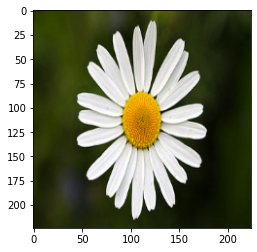

In [ ]:
random_index = int(np.random.choice(images.shape[0], 1))
plt.imshow(images[random_index])
plt.show()

## Train a nearest neighbors' model

In [ ]:
# Finding out nearest neighbors for the features of our query image
validation_features = facenet_like_model.predict(images)
start = time.time()
neighbors = NearestNeighbors(n_neighbors=5,
    algorithm='brute',
    metric='euclidean').fit(validation_features)
print('Time taken: {:.5f} secs'.format(time.time() - start))

Time taken: 0.00084 secs


In [ ]:
# Determine the neighbors nearest to our query image
distances, indices = neighbors.kneighbors([validation_features[random_index]])
for i in range(5):
    print(distances[0][i])

0.0
0.371705
0.42707968
0.6534044
0.6575869


## Visualize a neighbor

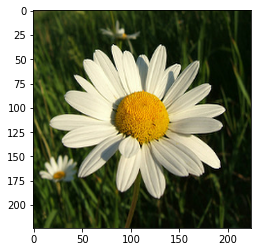

In [ ]:
plt.imshow(images[indices[0][1]], interpolation='lanczos')
plt.show()

## Visualizing the nearest neighbors for a few images

In [ ]:
def plot_images(images, labels, distances):
    plt.figure(figsize=(20, 10))
    columns = 4
    for (i, image) in enumerate(images):
        ax = plt.subplot(len(images) / columns + 1, columns, i + 1)
        if i == 0:
            ax.set_title("Query Image\n" + "Label: {}".format(CLASSES[labels[i]]))
        else:
            ax.set_title("Similar Image # " + str(i) +
                         "\nDistance: " +
                         str(float("{0:.2f}".format(distances[i]))) + 
                         "\nLabel: {}".format(CLASSES[labels[i]]))
        plt.imshow(image)

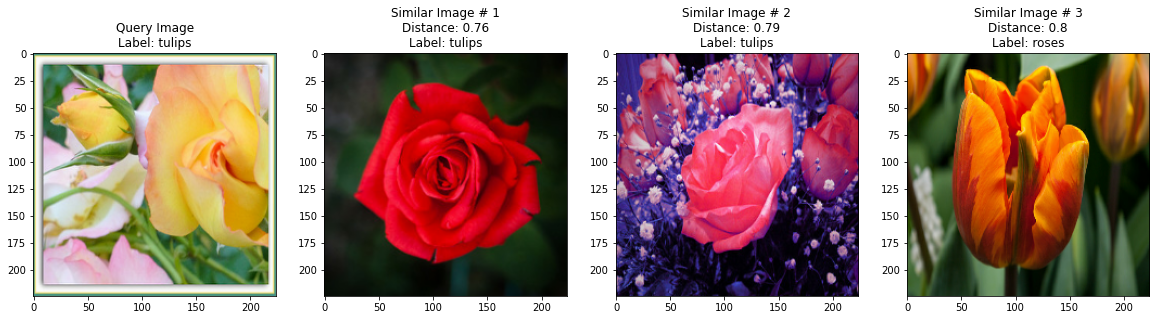

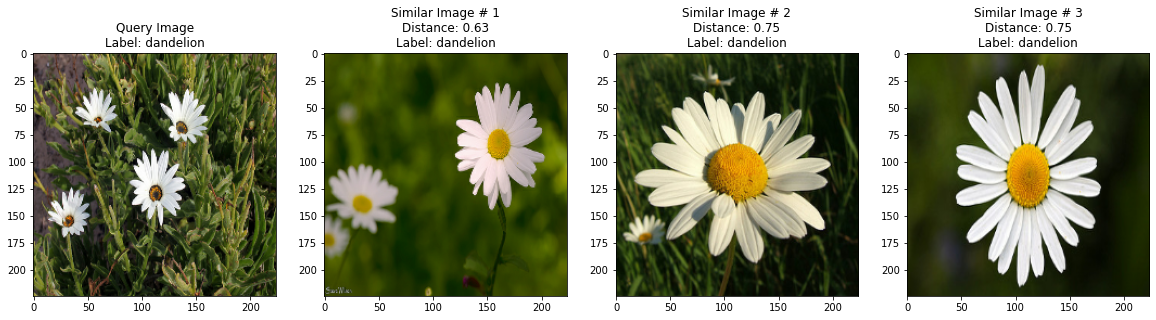

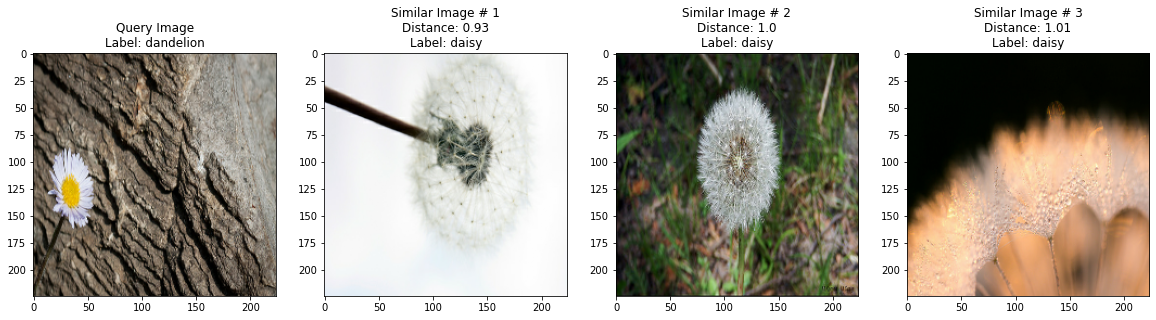

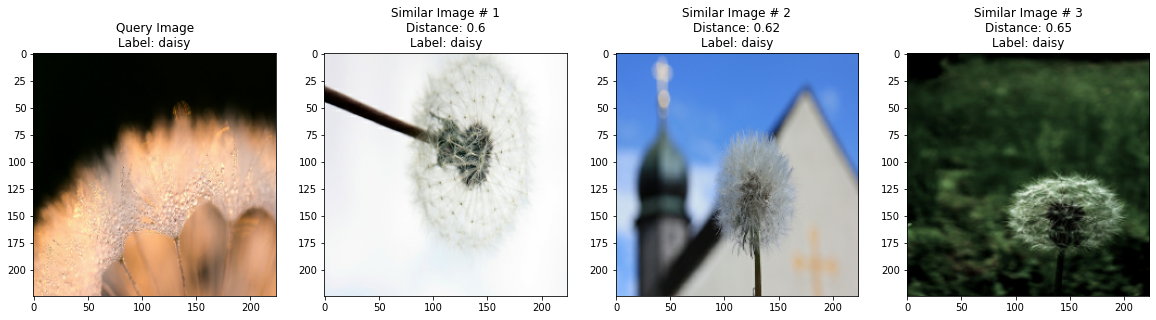

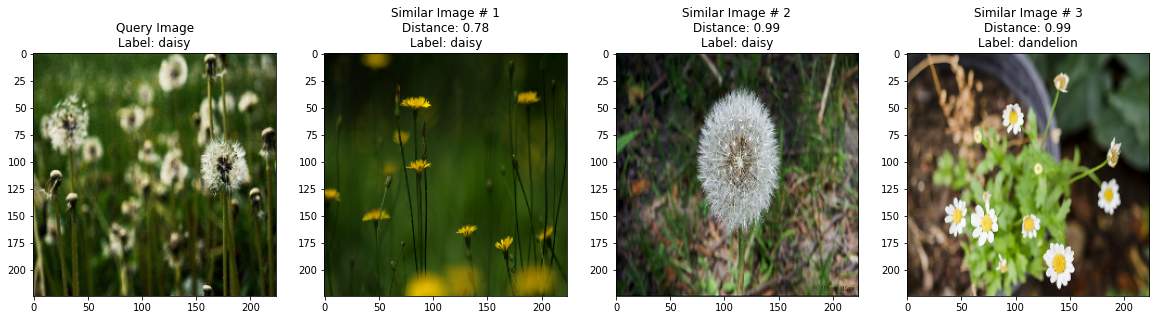

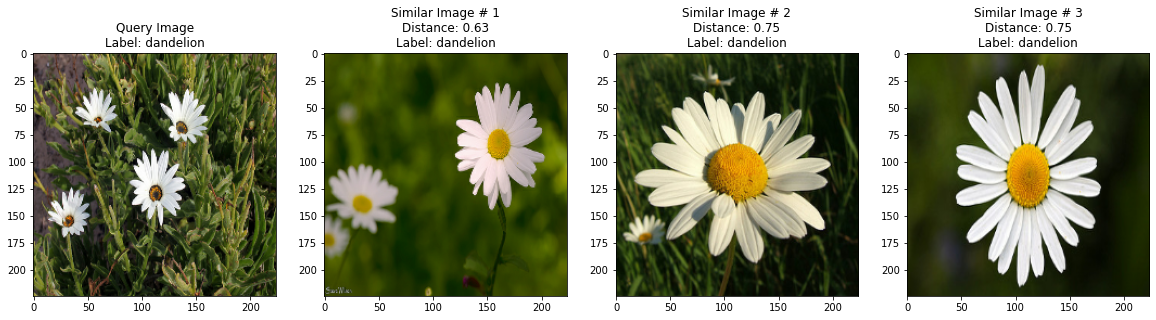

In [ ]:
for i in range(6):
    random_index = int(np.random.choice(images.shape[0], 1))
    distances, indices = neighbors.kneighbors(
        [validation_features[random_index]])
    
    # Don't take the first closest image as it will be the same image
    similar_images = [images[random_index]] + \
        [images[indices[0][i]] for i in range(1, 4)]
    similar_labels = [labels[random_index]] + \
        [labels[indices[0][i]] for i in range(1, 4)]
    plot_images(similar_images, similar_labels, distances[0])

**Observations**:

We see that tulips and roses are being treated similarly and so are dandelions and daisies. If we see there is indeed an overlap in between their shapes and textures and this is likely why this is happening. When dealing with problems where very few samples are available per class it's good to have very rich representative samples per class which are distinct and indicative of a given class. 

## Visualizing the embedding space of the batch

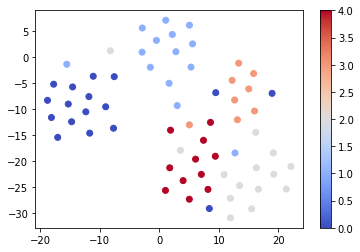

In [ ]:
tsne_results = TSNE(n_components=2).fit_transform(validation_features)

color_map = plt.cm.get_cmap('coolwarm')
scatter_plot = plt.scatter(tsne_results[:, 0],
                           tsne_results[:, 1],
                           c=labels,
                           cmap=color_map)
plt.colorbar(scatter_plot)
plt.show()

## Visualizing the embedding space of the entire test set (only 183 samples)

In [ ]:
validation_labels = [label
    for _, labels in validation_ds for label in labels
]
print(len(validation_labels))

183


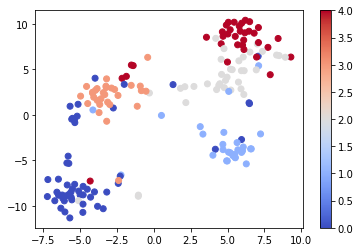

In [ ]:
validation_features = facenet_like_model.predict(validation_ds)

tsne_results = TSNE(n_components=2).fit_transform(validation_features)

color_map = plt.cm.get_cmap('coolwarm')
scatter_plot = plt.scatter(tsne_results[:, 0],
                           tsne_results[:, 1],
                           c=validation_labels,
                           cmap=color_map)
plt.colorbar(scatter_plot)
plt.show()